# Wikidata to CMU

We will load the `cmu_imdb_tmdb_merged.pkl` and add Wikidata to the dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_pickle('../../pickles/cmu_imdb_tmdb_merged.pkl')

<class 'pandas.core.frame.DataFrame'>


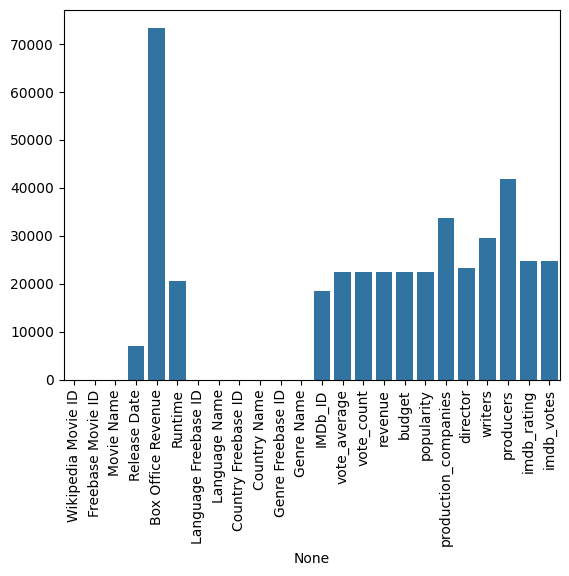

In [2]:
def plot_values_missing(df: pd.DataFrame):
  value_counts = df.isnull().sum()
  sns.barplot(x=value_counts.index, y=value_counts.values)
  plt.xticks(rotation=90)
  plt.show()


print(type(df))
plot_values_missing(df)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81855 entries, 0 to 81854
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wikipedia Movie ID    81855 non-null  int64  
 1   Freebase Movie ID     81855 non-null  object 
 2   Movie Name            81855 non-null  object 
 3   Release Date          74933 non-null  object 
 4   Box Office Revenue    8403 non-null   float64
 5   Runtime               61357 non-null  float64
 6   Language Freebase ID  81855 non-null  object 
 7   Language Name         81855 non-null  object 
 8   Country Freebase ID   81855 non-null  object 
 9   Country Name          81855 non-null  object 
 10  Genre Freebase ID     81855 non-null  object 
 11  Genre Name            81855 non-null  object 
 12  IMDb_ID               63350 non-null  object 
 13  vote_average          59403 non-null  float64
 14  vote_count            59403 non-null  float64
 15  revenue            

In [4]:
import requests

def fetch_wikidata_request():
  url = 'https://query.wikidata.org/sparql'
  query = f"""
    SELECT ?item ?IMDb_ID ?boxOffice  WHERE {{
      ?item wdt:P31 wd:Q11424 .
      ?item wdt:P345 ?IMDb_ID .
      ?item wdt:P2142 ?boxOffice .
    }}
    """
  r = requests.get(url, params = {'format': 'json', 'query': query})
  data = r.json()
  return data

def process_data(data):
  """
  Extracts a dataframe with IMDb_ID and box office revenue from the JSON data returned by the query
  Returns: the DataFrame with FreebaseID and IMDb_ID
  """
  transformed_data = [
      {
          'IMDb_ID': entry.get('IMDb_ID', {}).get('value', None),
          'Box Office Revenue': entry.get('boxOffice', {}).get('value', None)
      }
      for entry in data['results']['bindings']
  ]

  # Create a DataFrame
  df = pd.DataFrame(transformed_data)
  return df

In [5]:
data = fetch_wikidata_request()
new_df = process_data(data)


In [6]:
# Step 1: Filter rows in df where 'Box Office Revenue' is null
df_null_revenue = df[df['Box Office Revenue'].isnull()]

# Step 2: Merge the filtered df with new_df on 'IMDb_ID', avoiding column suffixes
merged_df = pd.merge(
    df_null_revenue, 
    new_df, 
    how='left', 
    on='IMDb_ID', 
    suffixes=('', '_new')
)

# Step 3: Replace the 'Box Office Revenue' column in df with the new values
# Only update where the new column has non-null values
merged_df['Box Office Revenue'] = merged_df['Box Office Revenue'].combine_first(merged_df['Box Office Revenue_new'])

# Drop the extra column after updating
merged_df = merged_df.drop(columns=['Box Office Revenue_new'])

# Step 4: Update the original df with the merged values
df.update(merged_df[['IMDb_ID', 'Box Office Revenue']])

/var/folders/jh/wtzfr62x0vd4dklqkf69gcv00000gn/T/ipykernel_90582/2084892308.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14010832.0 nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.update(merged_df[['IMDb_ID', 'Box Office Revenue']])


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81855 entries, 0 to 81854
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wikipedia Movie ID    81855 non-null  int64  
 1   Freebase Movie ID     81855 non-null  object 
 2   Movie Name            81855 non-null  object 
 3   Release Date          74933 non-null  object 
 4   Box Office Revenue    9607 non-null   object 
 5   Runtime               61357 non-null  float64
 6   Language Freebase ID  81855 non-null  object 
 7   Language Name         81855 non-null  object 
 8   Country Freebase ID   81855 non-null  object 
 9   Country Name          81855 non-null  object 
 10  Genre Freebase ID     81855 non-null  object 
 11  Genre Name            81855 non-null  object 
 12  IMDb_ID               75967 non-null  object 
 13  vote_average          59403 non-null  float64
 14  vote_count            59403 non-null  float64
 15  revenue            

In [8]:
df.to_pickle('../../pickles/cmu_imdb_tmdb_wikidata_merged.pkl')